## Imports, data and custom functions

In [32]:


# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

#Dataset
import os, glob
import PIL
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

#Tuning model
import visualkeras as vk
import keras_tuner as kt
from keras_tuner import HyperParameters as hp


# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)


def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()




def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)



def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict




### Importing data




In [2]:
# Checking the contents of xrays folder
data_dir = "data_dir"
# Getting list of img file paths (no folders)
img_files = glob.glob(data_dir+"**/*")
len(img_files)

3

## Dataset

### Creating Dataset

In [3]:
#Creating Dataset
# Saving image params as vars for future use
batch_size = 32
img_height = 96
img_width = 96

# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    shuffle=True,
    label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
ds



Found 6902 files belonging to 3 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [4]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size

216

In [5]:
# checking the class names
class_names = ds.class_names
class_names

['covid', 'normal', 'pneumonia']

In [6]:
# Saving # of classes for reuse
num_classes = len(class_names)
num_classes

3

In [7]:
# Saving dictionary of integer:string labels
class_dict = dict(zip(range(num_classes), class_names))
class_dict



{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [8]:
# Train test split

# Set the ratio of the train, validation, test split
split_train = 0.7
split_val = 0.2
split_test = .1 
# Calculate the number of batches for training and validation data 
n_train_batches =  int(ds_size * split_train)
n_val_batches = int(ds_size * split_val)

print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")



Use 151 batches as training data
Use 43 batches as validation data
The remaining 22 batches will be used as test data.


In [9]:
# Use .take to slice out the number of batches 
train_ds = ds.take(n_train_batches)
# Confirm the length of the training set
len(train_ds)



151

In [10]:
# Skip over the training batches
val_ds = ds.skip(n_train_batches)
# Take the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
# Confirm the length of the validation set
len(val_ds)



43

In [11]:
# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batches + n_val_batches)
# Confirm the length of the testing data
len(test_ds)



22

### Optimising Dataset

In [12]:
# Automatically determine best buffer sizes 
AUTOTUNE = tf.data.AUTOTUNE

# Make buffer size the same as the number of batches in train_ds
buffer_size = len(train_ds)
buffer_size



151

In [13]:
# Optimize training data
train_ds = train_ds.cache().shuffle(buffer_size= buffer_size,
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
# Optimize validation data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Optimize teset data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



## Previewing Dataset

In [14]:
# taking a sample batch to see batch shape
example_batch_imgs, example_batch_y= ds.take(1).get_single_element()
example_batch_imgs.shape

TensorShape([32, 96, 96, 3])

In [15]:
# Individual image shape
input_shape = example_batch_imgs[0].shape
input_shape


TensorShape([96, 96, 3])

In [16]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape


img_loaded

PermissionError: [Errno 13] Permission denied: 'data_dir\\covid'

In [17]:
# Preview y for first 5 of first batch
example_batch_y[0:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

## Modelling

### Simple model

In [18]:
# Write the building and compiling steps within a function

def build_simple_model():
    # Instantatie model
    model = models.Sequential()
    
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=4, 
            kernel_size=3, 
            input_shape=input_shape,
            padding='same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2)) 
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=4,  
            kernel_size=3,  
            input_shape=input_shape,
            padding='same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(3, activation="softmax") 
    ) 
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model



In [19]:
# Build the model
simple_model = build_simple_model()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 4)         112       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 4)         148       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 4)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0

In [20]:
# fit the neural network
epochs=15
history = simple_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, 
)

Epoch 1/15
151/151 [==============================] - 96s 404ms/step - loss: 0.6706 - accuracy: 0.7165 - val_loss: 0.6027 - val_accuracy: 0.7936
Epoch 2/15
151/151 [==============================] - 13s 87ms/step - loss: 0.5050 - accuracy: 0.8144 - val_loss: 0.4752 - val_accuracy: 0.8539
Epoch 3/15
151/151 [==============================] - 15s 101ms/step - loss: 0.4155 - accuracy: 0.8564 - val_loss: 0.4149 - val_accuracy: 0.8721
Epoch 4/15
151/151 [==============================] - 13s 89ms/step - loss: 0.3601 - accuracy: 0.8829 - val_loss: 0.3925 - val_accuracy: 0.8779
Epoch 5/15
151/151 [==============================] - 13s 86ms/step - loss: 0.3275 - accuracy: 0.8934 - val_loss: 0.3777 - val_accuracy: 0.8801
Epoch 6/15
151/151 [==============================] - 13s 85ms/step - loss: 0.3016 - accuracy: 0.8994 - val_loss: 0.3754 - val_accuracy: 0.8706
Epoch 7/15
151/151 [==============================] - 13s 85ms/step - loss: 0.2907 - accuracy: 0.9079 - val_loss: 0.3748 - val_accurac

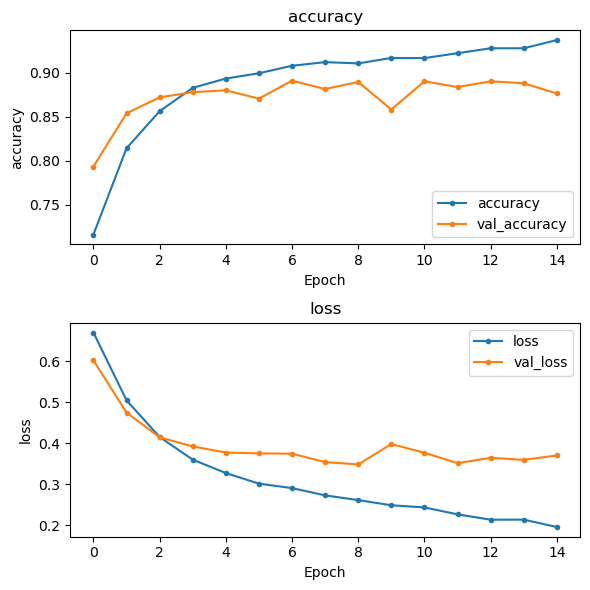


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       217
           1       0.89      0.82      0.86       256
           2       0.88      0.90      0.89       221

    accuracy                           0.88       694
   macro avg       0.88      0.88      0.88       694
weighted avg       0.88      0.88      0.88       694



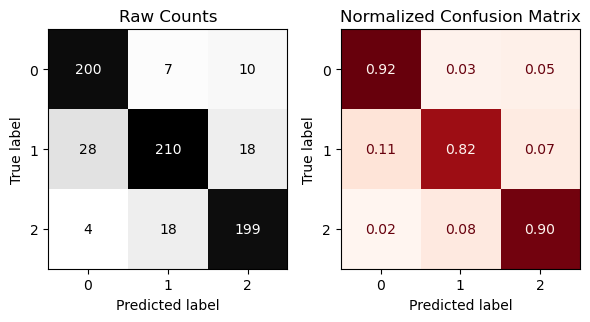


- Evaluating Test Data:
22/22 [==============================] - 1s 41ms/step - loss: 0.3724 - accuracy: 0.8775
{'loss': 0.37241533398628235, 'accuracy': 0.8775216341018677}


In [21]:
# Testing with the CNN + Dataset
evaluate_classification_network(simple_model, X_test=test_ds, history=history);

### More complex model

In [22]:
#Tuning the model 

def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

# Write the building and compiling steps within a function

def build_comp_model():
    # Instantatie model
    model = models.Sequential()
    
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16, 
            kernel_size=5, 
            input_shape=input_shape,
            padding='same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2, strides = 1)) 
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,  
            kernel_size=5,  
            input_shape=input_shape,
            padding='same'
        )) 

        # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=20,  
            kernel_size=5,  
            input_shape=input_shape,
            padding='same'
        )) 
    
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2, strides = 1))  
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(3, activation="softmax") 
    ) 
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 16)        1216      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 95, 95, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 16)        6416      
                                                                 
 conv2d_4 (Conv2D)           (None, 95, 95, 20)        8020      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 94, 94, 20)       0         
 2D)                                                  

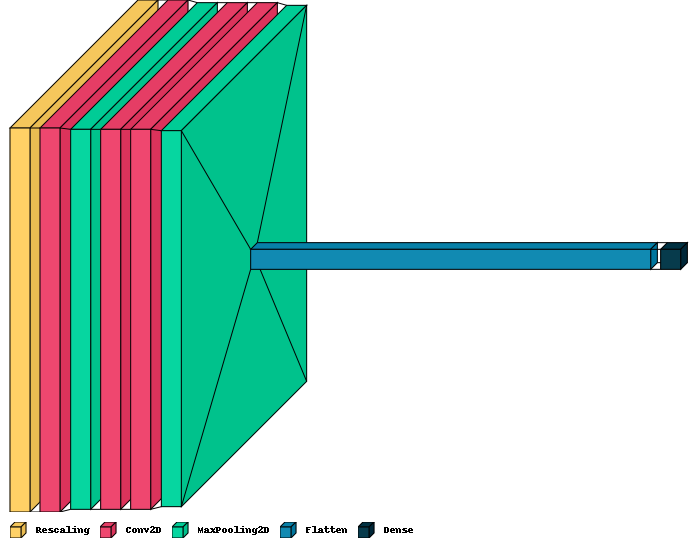

In [23]:
# Build model and visualize
comp_model = build_comp_model()
vk.layered_view(comp_model, legend=True)



In [24]:
# Build new model and fit 
comp_model = build_comp_model()
history = comp_model.fit(
    train_ds, validation_data=val_ds, epochs=25, callbacks=get_callbacks()
)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 16)        1216      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 95, 95, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 95, 95, 16)        6416      
                                                                 
 conv2d_7 (Conv2D)           (None, 95, 95, 20)        8020      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 94, 94, 20)       0         
 2D)                                                  

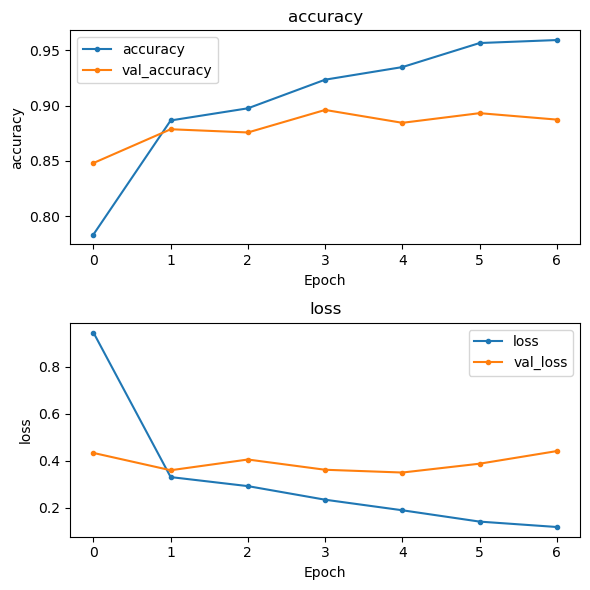


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1587
           1       0.98      0.97      0.98      1623
           2       0.98      0.99      0.98      1622

    accuracy                           0.98      4832
   macro avg       0.98      0.98      0.98      4832
weighted avg       0.98      0.98      0.98      4832



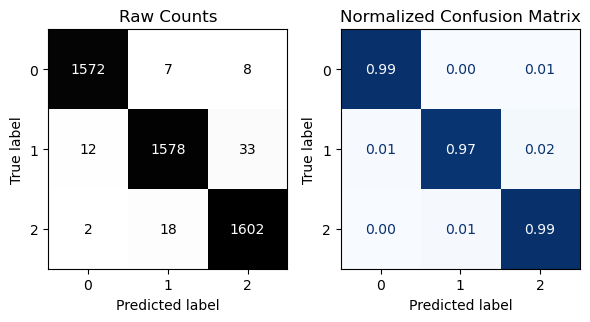


- Evaluating Training Data:
151/151 [==============================] - 35s 231ms/step - loss: 0.0719 - accuracy: 0.9834
{'loss': 0.07185950130224228, 'accuracy': 0.9834437370300293}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       217
           1       0.88      0.84      0.86       256
           2       0.83      0.89      0.86       221

    accuracy                           0.88       694
   macro avg       0.88      0.88      0.88       694
weighted avg       0.88      0.88      0.88       694



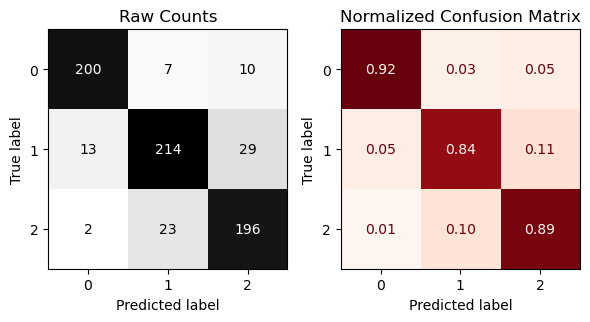


- Evaluating Test Data:
22/22 [==============================] - 5s 219ms/step - loss: 0.4074 - accuracy: 0.8790
{'loss': 0.40741437673568726, 'accuracy': 0.878962516784668}


In [25]:
evaluate_classification_network(
    comp_model, X_train=train_ds,  X_test=test_ds, history=history);



### Transfer Learning model

16705208/16705208 [==============================] - 13s 1us/step


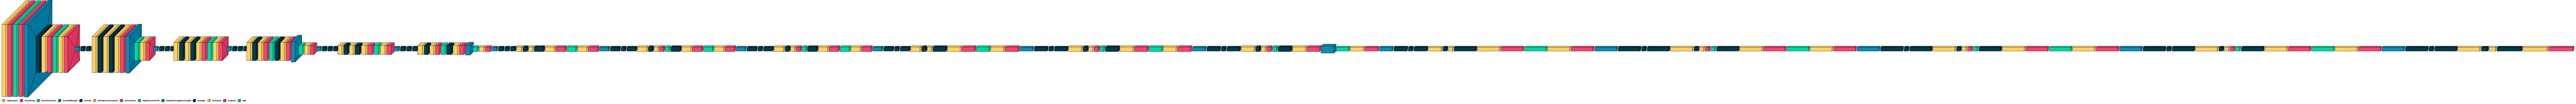

In [26]:
# Download EfficientNet base
efficientnet_base =tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape)

# Make it not-trainable
efficientnet_base.trainable=False
vk.layered_view(efficientnet_base, legend=True)



In [28]:
def get_callbacks(monitor='val_accuracy', patience=3, restore_best_weights=False):
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience, 
                                                      restore_best_weights=restore_best_weights)
    return [early_stopping]



# add preprocessing lambda layer
lambda_layer_efficient = tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, 
                                      name='preprocess_input_enet'
                                               )

def build_efficientnet_model():
    model = models.Sequential(name="EfficientNetB0")
    # Use input layer (lambda layer will handle rescaling).
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lambda layer
    model.add(lambda_layer_efficient)

    # Add pretrained base
    model.add(efficientnet_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(class_names), activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    model.summary()
    return model


In [29]:
#Building transfer model
model_efnet = build_efficientnet_model()
model_efnet.summary()

Model: "EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input_enet (Lamb  (None, 96, 96, 3)        0         
 da)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 3, 3, 1280)       4049571   
                                                                 
 flatten_3 (Flatten)         (None, 11520)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               2949376   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 771       
                                                    

Model: "EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input_enet (Lamb  (None, 96, 96, 3)        0         
 da)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 3, 3, 1280)       4049571   
                                                                 
 flatten_5 (Flatten)         (None, 11520)             0         
                                                                 
 dense_7 (Dense)             (None, 256)               2949376   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 3)                 771       
                                                    

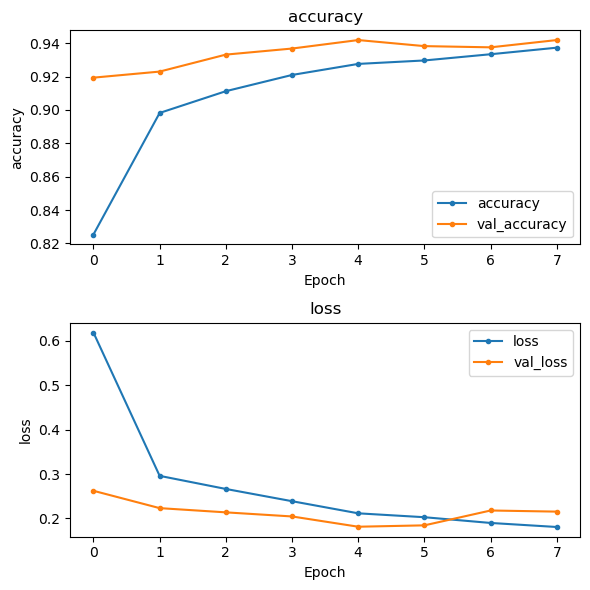


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       217
           1       0.89      0.94      0.91       256
           2       0.95      0.90      0.93       221

    accuracy                           0.93       694
   macro avg       0.93      0.93      0.93       694
weighted avg       0.93      0.93      0.93       694



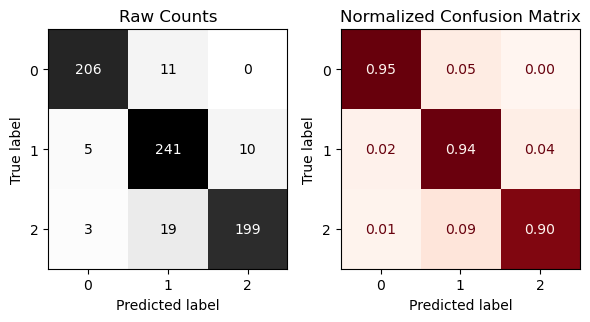


- Evaluating Test Data:
22/22 [==============================] - 8s 351ms/step - loss: 0.2551 - accuracy: 0.9308
{'loss': 0.25511008501052856, 'accuracy': 0.9308357238769531}


In [31]:
#Building and evaluating model
model_efnet=build_efficientnet_model()
history = model_efnet.fit(train_ds, validation_data=val_ds, epochs=15, 
                    callbacks=get_callbacks()
                         )
#Evaluating network
evaluate_classification_network(model_efnet, X_test=test_ds, history=history);



## Conclusion

|Model| Accuracy | Precision| Recall|
|---|---|---|---|
|Simple model|0.88|0.88|0.88|
|Complex model|0.88|0.88|0.88|
|Transfered model|0.93|0.93|0.93|

The best model was : Transferred model (Efficientnet)


In [33]:
#Saving model
folder = 'KerasModel/'
os.makedirs(folder, exist_ok=True)


In [44]:
#model_efnet.save("KerasModel/model.keras", save_format="keras")
#  error saving efficient net model

#Saving simple model instead
simple_model.save("model.keras", save_format="keras")

In [37]:
model_efnet.save?


Signature: model_efnet.save(filepath, overwrite=True, save_format=None, **kwargs)
Docstring:
Saves a model as a TensorFlow SavedModel or HDF5 file.

See the [Serialization and Saving guide](
    https://keras.io/guides/serialization_and_saving/) for details.

Args:
    model: Keras model instance to be saved.
    filepath: `str` or `pathlib.Path` object. Path where to save the
        model.
    overwrite: Whether we should overwrite any existing model at the
        target location, or instead ask the user via an interactive
        prompt.
    save_format: Either `"keras"`, `"tf"`, `"h5"`,
        indicating whether to save the model
        in the native Keras format (`.keras`),
        in the TensorFlow SavedModel format
        (referred to as "SavedModel" below),
        or in the legacy HDF5 format (`.h5`).
        Defaults to `"tf"` in TF 2.X, and `"h5"` in TF 1.X.

SavedModel format arguments:
    include_optimizer: Only applied to SavedModel and legacy HDF5
        formats. I